In [7]:
from langgraph.graph import StateGraph, MessagesState, START,  END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.prebuilt import create_react_agent, ToolNode, tools_condition
from sqlalchemy import create_engine, inspect
from pydantic import BaseModel
from sqlalchemy import text

from azure_openai_llm import get_llm

# State class
class DBState(MessagesState):
    query: str = None
    result: str = None

class SQLQuery(BaseModel):
    query: str

class DBAgent:
    def __init__(self, db):
        self.llm = get_llm()
        self.memory = MemorySaver()
        self.db = db
        self.metadata = self.get_schema_metadata()
        print("DB Metadata:", self.metadata)
    
    def get_schema_metadata(self):
        engine = create_engine(self.db)
        inspector = inspect(engine)
        schema_info = {}

        for table_name in inspector.get_table_names():
            columns = inspector.get_columns(table_name)
            foreign_keys = inspector.get_foreign_keys(table_name)
            schema_info[table_name] = {
                "columns": [
                    {"name": col["name"], "type": str(col["type"]), "nullable": col["nullable"]}
                    for col in columns
                ],
                "foreign_keys": foreign_keys,
                "primary_key": inspector.get_pk_constraint(table_name)["constrained_columns"]
            }
        return schema_info
    
    def extract_user_intent(self, prior_messages, latest_message):
        # Format prior messages for context
        convo_history = "\n".join(
            f"{'User' if isinstance(m, HumanMessage) else 'Assistant'}: {m.content}"
            for m in prior_messages
        )

        prompt = f"""
        You are an AI assistant helping to write SQL queries.

        Here is the previous conversation for context:

        {convo_history}

        Now the user says:

        User: {latest_message.content}

        Your job is to extract the **exact intent** of the latest user message,
        based on the full context above. Do NOT summarize the whole conversation.

        Just return the full user intent clearly, in one natural language sentence.

        If no clear intent is found, return: "No query found."
        """

        response = self.llm.invoke(prompt)
        return response.content.strip()

    
    def format_schema(self) -> str:
        """
        Converts parsed schema dict into a readable schema format for the LLM.
        """
        formatted = []
        for table_name, table_data in self.metadata.items():
            columns = ", ".join(
                f"{col['name']} ({col['type']})"
                for col in table_data.get("columns", [])
            )
            formatted.append(f"Table: {table_name}\n  Columns: {columns}")
        return "\n\n".join(formatted)


    # Tool to generate SQL queries
    def generate_sql_query(self, state: DBState) -> DBState:
        """
        Generates an SQL query based on the last message in state["messages"].
        """
        all_messages = state["messages"]
        prior_messages = all_messages[:-1]
        latest_message = all_messages[-1]

        if not isinstance(latest_message, HumanMessage):
            return {"result": "Invalid or missing user message."}

        user_query = self.extract_user_intent(prior_messages, latest_message)
        if user_query == "No query found.":
            return {"result": "No actionable query found in the latest message."}
        
        print("User Query:", user_query)
        
        # Use the structured output definition
        sql_generator = self.llm.with_structured_output(SQLQuery)

        schema_str = self.format_schema()
        prompt = f"""
        You are an expert data analyst and SQL assistant.

        Given the following database schema:

        {schema_str}

        Analyze the following user question and identify which tables and columns are relevant. 
        Then write a syntactically correct SQL query based only on the tables and columns from the schema above.

        User question:
        \"\"\"{user_query}\"\"\"

        Be accurate and use appropriate SQL functions for date, text, or numerical filtering if needed. 
        Only use the tables and columns listed in the schema. Do not assume extra fields or tables.
        Return ONLY the SQL query, without explanation.
        """

        # Invoke the LLM
        sql_response = sql_generator.invoke(prompt)

        # Get the query string
        generated_query = sql_response.query
        print("Generated SQL:", generated_query)

        return {
            **state,
            "query": generated_query,
            "result": generated_query
        }

    def execute_sql_query(self, state: DBState) -> DBState:
        """
        Executes the generated SQL query stored in state.query and returns the result.
        """
        if not state["query"]:
            return {**state, "result": "No query found to execute."}

        try:
            engine = create_engine(self.db)
            with engine.connect() as connection:
                result_proxy = connection.execute(text(state["query"]))
                rows = result_proxy.fetchall()
                column_names = result_proxy.keys()

                # Format results as a list of dictionaries
                results = [dict(zip(column_names, row)) for row in rows]
                print("\n\nQuery Results:", results, "\n\n")
                return {
                    **state,
                    "result": results
                }
        except Exception as e:
            return {
                **state,
                "result": f"Query execution failed: {str(e)}"
            }


    def create_DB_Graph(self):
        graph_builder = StateGraph(DBState)

        # Add nodes
        graph_builder.add_node("generate_sql_query", self.generate_sql_query)
        graph_builder.add_node("execute_sql_query", self.execute_sql_query)

        # Set flow: generate → execute
        graph_builder.set_entry_point("generate_sql_query")
        graph_builder.add_edge("generate_sql_query", "execute_sql_query")
        graph_builder.set_finish_point("execute_sql_query")

        return graph_builder.compile(checkpointer=self.memory)


# Instantiate the agent and create the graph
db_agent = DBAgent("sqlite:///northwind.db")
graph = db_agent.create_DB_Graph()

# Create a test input
test_state = {
    "messages": [HumanMessage(content="get the Employee details who are hoired before 2013 and get all the suppliers who are in the UK")]
}

config = {"configurable": {"thread_id": "thread_1"}}
# Run the graph
final_state = graph.invoke(test_state, config=config)
print("Final State:", final_state)




Client ID and Client Secret found -- Initializing -- AzureChatOpenAI
DB Metadata: {'Categories': {'columns': [{'name': 'CategoryID', 'type': 'INTEGER', 'nullable': True}, {'name': 'CategoryName', 'type': 'TEXT', 'nullable': True}, {'name': 'Description', 'type': 'TEXT', 'nullable': True}, {'name': 'Picture', 'type': 'BLOB', 'nullable': True}], 'foreign_keys': [], 'primary_key': ['CategoryID']}, 'CustomerCustomerDemo': {'columns': [{'name': 'CustomerID', 'type': 'TEXT', 'nullable': False}, {'name': 'CustomerTypeID', 'type': 'TEXT', 'nullable': False}], 'foreign_keys': [{'name': None, 'constrained_columns': ['CustomerTypeID'], 'referred_schema': None, 'referred_table': 'CustomerDemographics', 'referred_columns': ['CustomerTypeID'], 'options': {}}, {'name': None, 'constrained_columns': ['CustomerID'], 'referred_schema': None, 'referred_table': 'Customers', 'referred_columns': ['CustomerID'], 'options': {}}], 'primary_key': ['CustomerID', 'CustomerTypeID']}, 'CustomerDemographics': {'colum

Client ID and Client Secret found -- Initializing -- AzureChatOpenAI


2025-04-19 17:01:23,032 - INFO - Schema metadata retrieved successfully.


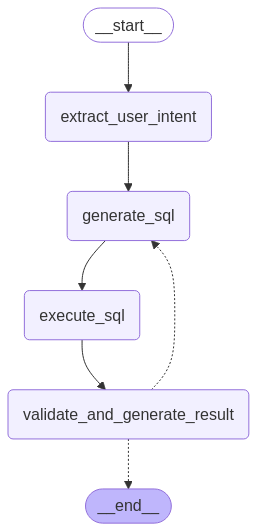

2025-04-19 17:01:27,330 - INFO - HTTP Request: POST https://chat-ai.cisco.com/openai/deployments/gpt-4o-mini/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-04-19 17:01:27,339 - INFO - User intent extracted successfully.
2025-04-19 17:01:28,346 - INFO - HTTP Request: POST https://chat-ai.cisco.com/openai/deployments/gpt-4o-mini/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-04-19 17:01:28,420 - INFO - SQL query generated successfully.
2025-04-19 17:01:28,504 - INFO - Query executed successfully.
2025-04-19 17:01:28,514 - INFO - SQL query executed successfully.
2025-04-19 17:01:28,990 - INFO - HTTP Request: POST https://chat-ai.cisco.com/openai/deployments/gpt-4o-mini/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-04-19 17:01:28,999 - INFO - Retrying request to /chat/completions in 0.471299 seconds
2025-04-19 17:01:29,779 - INFO - HTTP Request: POST https://chat-ai.cisco.com/openai/deployments/gpt-4o-m

Final Result: [{'result': [{'TotalEmployees': 9}]}]
__________ The query you executed successfully counted the total number of employees in the database. The results show that there are a total of 9 employees recorded in the 'employees' table. __________


In [2]:
from DB_Agent import SQLiteAdapter, ModularDBAgent, get_llm, DBState, HumanMessage
from IPython.display import display, Image

db = SQLiteAdapter("sqlite:///northwind.db")

llm = get_llm()

agent = ModularDBAgent(db=db, llm=llm)
graph = agent.compile_graph()

initial_state = DBState(messages=[
    HumanMessage(content="How Many employees are there in the database?"),
])

display(Image(graph.get_graph().draw_mermaid_png()))

result = graph.invoke(initial_state, config={"configurable": {"thread_id": "thread_1"}})
print("Final Result:", result["result"])

print("__________", result["messages"][-1].content, "__________")

In [3]:
# async def run_research_agent_stream(user_message: str, thread_id: str = "default_thread"):
#     config = {"configurable": {"thread_id": thread_id}}
#     initial_state = {
#         "messages": [HumanMessage(content=user_message)],
#         "research_needed": False,
#         "wikipedia_results": [],
#         "tavily_results": [],
#         "final_response": ""
#     }

#     async for event in graph.astream_events(initial_state, config):
#         if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node") == "generate_response":
#             data = event["data"]
#             print(data["chunk"].content, end="", flush=True)

from DB_Agent import SQLiteAdapter, ModularDBAgent, get_llm, DBState, HumanMessage
from IPython.display import display, Image

db = SQLiteAdapter("sqlite:///northwind.db")

llm = get_llm()

agent = ModularDBAgent(db=db, llm=llm)
graph = agent.compile_graph()

async def db_agent_stream(user_message: str, thread_id: str = "default_thread"):
    config = {"configurable": {"thread_id": thread_id}}
    initial_state = DBState(messages=[
        HumanMessage(content="How Many employees are there in the database?"),
    ])

    async for event in graph.invoke(initial_state, config=config):
        if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node") == "validate_and_generate_result":
            data = event["data"]
            print(data["chunk"].content, end="", flush=True)




Client ID and Client Secret found -- Initializing -- AzureChatOpenAI


2025-04-19 17:30:09,394 - INFO - Schema metadata retrieved successfully.
